# Выпускной проект

## Постановка задач

В мобильном приложении "Ненужные вещи" необходимо провести анализ влияния различных событий на совершение целевого действия (пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления), а также оценить, какие события чаще всего совершают пользователи, совершающие целевое действие.

## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
from plotly import graph_objects as go
from datetime import datetime, timedelta
import seaborn as sns
import math as mth
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format='svg'

pd.options.display.max_columns = None
pd.option_context.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
try:
    mobile_sourсes = pd.read_csv(r'C:\Users\Иванов\mobile_sourсes.csv')
    mobile_dataset = pd.read_csv(r'C:\Users\Иванов\mobile_dataset.csv')  
except FileNotFoundError as e:
    print(repr(e))
    mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

### Проверка на пропуски и дубликаты

In [3]:
display(mobile_sourсes.head())
mobile_sourсes.info()
print(f"Количество дубликатов в датафрейме: {mobile_sourсes.duplicated().sum()}")

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
Количество дубликатов в датафрейме: 0


In [4]:
display(mobile_dataset.head())
mobile_dataset.info()
print(f"Количество дубликатов в датафрейме: {mobile_dataset.duplicated().sum()}")

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
Количество дубликатов в датафрейме: 0


In [5]:
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.columns = ['date_time', 'event_name', 'user_id']

Пропусков и дубликатов нет.

### Замена типов данных

In [6]:
mobile_dataset['date_time'] = pd.to_datetime(mobile_dataset['date_time'])
mobile_dataset['date_time'] = mobile_dataset['date_time'].astype('datetime64[s]')

### Объединение датафреймов

In [7]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
df.head()

,date_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [8]:
df['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Объединяем события search и show_contacts-contacts_show.

In [9]:
df['event_name'] = df['event_name'].str.replace('search_1', 'search')
df['event_name'] = df['event_name'].str.replace('search_2', 'search')
df['event_name'] = df['event_name'].str.replace('search_3', 'search')
df['event_name'] = df['event_name'].str.replace('search_4', 'search')
df['event_name'] = df['event_name'].str.replace('search_5', 'search')
df['event_name'] = df['event_name'].str.replace('search_6', 'search')
df['event_name'] = df['event_name'].str.replace('search_7', 'search')
df['event_name'] = df['event_name'].str.replace('show_contacts', 'contacts_show')

In [10]:
df['source'].value_counts()

yandex    34286
google    20445
other     19466
Name: source, dtype: int64

Больше всего пользователей привлечено с Яндекса

In [11]:
df.describe()

,date_time,event_name,user_id,source
count,74197,74197,74197,74197
unique,71291,9,4293,3
top,2019-10-27 20:00:06,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex
freq,9,40055,478,34286
first,2019-10-07 00:00:00,NaN,NaN,NaN
last,2019-11-03 23:58:12,NaN,NaN,NaN


В нашем распоряжении данные с 2019-10-07 00:00:00 по 2019-11-03 23:58:12, т.е. полные 4 недели.

Самое распространенное событие tips_show (пользователь увидел рекомендованные объявления)

## Исследовательский анализ данных

Выведем в отдельные столбцы недели и дни.

In [12]:
df['event_date'] = df['date_time'].dt.date
df['event_week'] = df['date_time'].dt.isocalendar().week

In [13]:
display(df.head())

,date_time,event_name,user_id,source,event_date,event_week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41


Рассчитаем сессии пользователей. Одна сессия = один день

In [14]:
df1 = df.pivot_table(index=['user_id','event_date','event_week'], values='date_time', aggfunc=['min','max'])
df1.columns = ['session_start', 'session_finish']
df1['time_session'] = df1['session_finish'] - df1['session_start']
df1=df1.reset_index()

In [15]:
display(df1.head())

,user_id,event_date,event_week,session_start,session_finish,time_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,41,2019-10-07 13:39:45,2019-10-07 13:49:41,0 days 00:09:56
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,41,2019-10-09 18:33:55,2019-10-09 18:42:22,0 days 00:08:27
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,43,2019-10-21 19:52:30,2019-10-21 20:07:30,0 days 00:15:00
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,43,2019-10-22 11:18:14,2019-10-22 11:30:52,0 days 00:12:38
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,42,2019-10-19 21:34:33,2019-10-19 21:59:54,0 days 00:25:21


In [16]:
df1.describe()

,event_week,time_session
count,7817.000000,7817
mean,42.629909,0 days 01:23:02.005117052
std,1.072018,0 days 03:10:10.086282725
min,41.000000,0 days 00:00:00
25%,42.000000,0 days 00:02:28
50%,43.000000,0 days 00:11:48
75%,44.000000,0 days 00:48:45
max,44.000000,0 days 23:37:28


Максимальное время сессии 23:37:28. Удалим сессии больше 1 часа. Нулевые трогать не будем. Возможно, алгоритм работы приложения подразумевает выполнение целевого действия без выполнения других шагов.

In [17]:
df1 = df1.query('time_session < "0 days 01:00:00"').reset_index(drop=True)

In [18]:
df1.describe()

,event_week,time_session
count,6050.000000,6050
mean,42.614876,0 days 00:12:01.119338842
std,1.070862,0 days 00:13:59.824850454
min,41.000000,0 days 00:00:00
25%,42.000000,0 days 00:01:05.250000
50%,43.000000,0 days 00:06:41
75%,44.000000,0 days 00:18:12
max,44.000000,0 days 00:59:54


Среднее время сессии 12 минут, медианное почти 7 минут.


In [19]:
dau_total = df1.groupby('event_date').agg({'user_id': 'nunique'}).mean()
dau_total

user_id    216.071429
dtype: float64

Среднее количество уникальных пользователей в день 216

In [20]:
wau_total = df1.groupby('event_week').agg({'user_id': 'nunique'}).mean()
wau_total

user_id    1189.75
dtype: float64

Среднее количество уникальных пользователей в неделю 1189

Расчитаем еще метрику — sticky factor

In [21]:
sticky_factor = dau_total / wau_total * 100
sticky_factor

user_id    18.161078
dtype: float64

Общее время в приложении и количество сессий на пользователя

In [22]:
user_sessions = df1.pivot_table(index=['user_id'], values='time_session', aggfunc=['count','sum'])
user_sessions.columns = ['session_count', 'session_sum']
display(user_sessions.head(10))

,session_count,session_sum
user_id,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:46:01
00157779-810c-4498-9e05-a1e9e3cedf93,5,0 days 02:00:02
00463033-5717-4bf1-91b4-09183923b9df,1,0 days 00:24:42
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5,0 days 01:22:37
00551e79-152e-4441-9cf7-565d7eb04090,3,0 days 00:09:19
005fbea5-2678-406f-88a6-fbe9787e2268,1,0 days 00:10:48
00653802-5ff1-4071-bc17-347fc4cef569,1,0 days 00:08:31
006a32d4-ee10-40dc-b237-11e0fde81cbc,1,0 days 00:15:42
006f6ced-225b-4f9c-9f17-23404bc6835f,1,0 days 00:09:05


In [23]:
user_sessions.describe()

,session_count,session_sum
count,3775.000000,3775
mean,1.602649,0 days 00:19:15.701192052
std,1.239046,0 days 00:21:23.857342926
min,1.000000,0 days 00:00:00
25%,1.000000,0 days 00:04:47.500000
50%,1.000000,0 days 00:11:58
75%,2.000000,0 days 00:27:29
max,20.000000,0 days 03:40:30


Количество пользователей по событиям и количество событий

In [24]:
events = df.groupby('event_name')['user_id'].agg(['count', 'nunique']).reset_index()
events.columns =['event_name', 'n_events', 'n_users']
events = events.sort_values(by='n_events', ascending=False)
display(events)

,event_name,n_events,n_users
8,tips_show,40055,2801
5,photos_show,10012,1095
6,search,6784,1666
0,advert_open,6164,751
2,contacts_show,4529,981
4,map,3881,1456
3,favorites_add,1417,351
7,tips_click,814,322
1,contacts_call,541,213


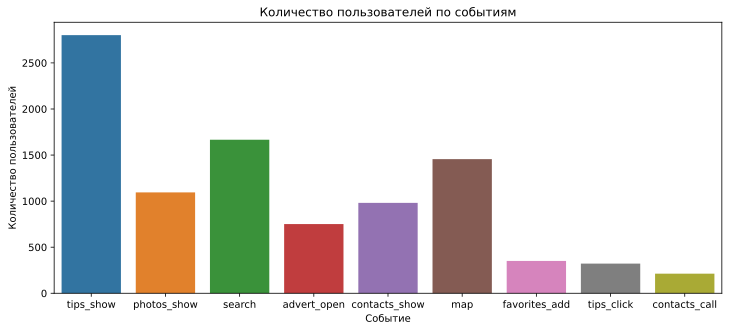

In [25]:
plt.figure(figsize=(12,5))
plt.title("Количество пользователей по событиям")
sns.barplot(x='event_name', y='n_users', data=events, ci=None)
plt.xlabel("Событие")
plt.ylabel("Количество пользователей")
plt.show()

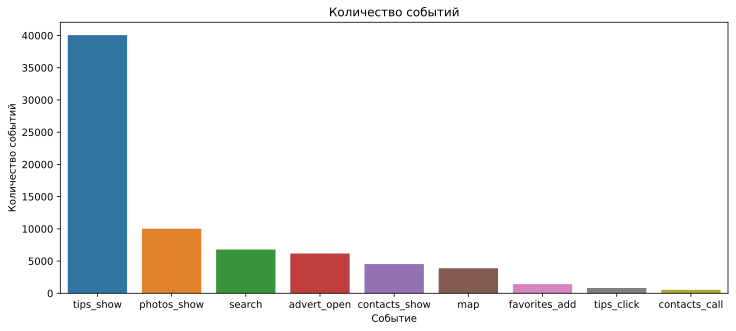

In [26]:
plt.figure(figsize=(12,5))
plt.title("Количество событий")
sns.barplot(x='event_name', y='n_events', data=events, ci=None)
plt.xlabel("Событие")
plt.ylabel("Количество событий")
plt.show()

Самое популярное событие - tips_show (автоматически показывается всем пользователям). На втором месте - photos_show, хотя пользователей его совершающих меньше чем search. 

Меньше всего событий contacts_call. Скорее всего многие пользователи производят звонки не используя приложение.

## Статистический анализ данных

### Сегментация пользователей

Для дальнейшего анализа поделим пользователей на 2 категории:

1. Пользователи совершившие действие favorites_add

2. Пользователи не совершавшие действие favorites_add

In [27]:
df_1 = df.query('"favorites_add" in event_name')
df_1['category']='1'
df_1 = df_1[['user_id', 'category']].drop_duplicates().reset_index(drop=True)

In [28]:
df = df.merge(df_1, on='user_id', how='left')
df['category'] = df['category'].fillna('0')
df.head(5)

,date_time,event_name,user_id,source,event_date,event_week,category
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,41,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,41,0


### Конверсия в целевое действие 

In [29]:
df_cat_1 = df.query('"1" in category')

In [30]:
df_cat_0 = df.query('"0" in category')

In [31]:
contacts_show_1 = df_cat_1[df_cat_1['event_name'] =='contacts_show']['user_id'].nunique()
contacts_show_0 = df_cat_0[df_cat_0['event_name'] =='contacts_show']['user_id'].nunique()
no_contacts_show_1 = df_cat_1[df_cat_1['event_name'] !='contacts_show']['user_id'].nunique()
no_contacts_show_0 = df_cat_0[df_cat_0['event_name'] !='contacts_show']['user_id'].nunique()

In [32]:
print(f"Общая конверсия всех событий в contacts_show для 1 категории пользователей' = {round((contacts_show_1/no_contacts_show_1*100), 2)}%")
print(f"Общая конверсия всех событий в contacts_show для 0 категории пользователей' = {round((contacts_show_0/no_contacts_show_0*100), 2)}%")

Общая конверсия всех событий в contacts_show для 1 категории пользователей' = 38.75%
Общая конверсия всех событий в contacts_show для 0 категории пользователей' = 21.62%


Конвесия пользователей 1 категории (пользователи совершившие действие favorites_add) заметно выше.

### Какие пользователи склонны часто возвращаться в мобильное приложение?

In [33]:
min_event_datetime_1 = df_cat_1.groupby(['user_id'])['date_time'].min()
min_event_datetime_1.name = 'min_event_datetime'
df_cat_1 = df_cat_1.join(min_event_datetime_1,on='user_id')
df_cat_1['time_to_event'] = df_cat_1['date_time'] - df_cat_1['min_event_datetime']
df_cat_1['event_week'] = (pd.to_datetime(df_cat_1['date_time'].dt.date) - pd.to_timedelta(df_cat_1['date_time'].dt.dayofweek, unit='d'))
df_cat_1['min_event_week'] = (pd.to_datetime(df_cat_1['min_event_datetime'].dt.date) - pd.to_timedelta(df_cat_1['min_event_datetime'].dt.dayofweek, unit='d'))
df_cat_1['lifetime'] = df_cat_1['event_week'] - df_cat_1['min_event_week']
df_cat_1['lifetime'] = (df_cat_1['lifetime'] / np.timedelta64(1,'W')).astype(int)

In [34]:
result_grouped_1 = df_cat_1.pivot_table(
    index=['min_event_week'], columns='lifetime', values='user_id', aggfunc='nunique'
)

cohort_sizes_1 = (
    df_cat_1.groupby('min_event_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

result_grouped_1 = cohort_sizes_1.merge(
    result_grouped_1, on='min_event_week', how='left'
).fillna(0)

In [35]:
min_event_datetime_0 = df_cat_0.groupby(['user_id'])['date_time'].min()
min_event_datetime_0.name = 'min_event_datetime'
df_cat_0 = df_cat_0.join(min_event_datetime_0,on='user_id')
df_cat_0['time_to_event'] = df_cat_0['date_time'] - df_cat_0['min_event_datetime']
df_cat_0['event_week'] = (pd.to_datetime(df_cat_0['date_time'].dt.date) - pd.to_timedelta(df_cat_0['date_time'].dt.dayofweek, unit='d'))
df_cat_0['min_event_week'] = (pd.to_datetime(df_cat_0['min_event_datetime'].dt.date) - pd.to_timedelta(df_cat_0['min_event_datetime'].dt.dayofweek, unit='d'))
df_cat_0['lifetime'] = df_cat_0['event_week'] - df_cat_0['min_event_week']
df_cat_0['lifetime'] = (df_cat_0['lifetime'] / np.timedelta64(1,'W')).astype(int)

In [36]:
result_grouped_0 = df_cat_0.pivot_table(
    index=['min_event_week'], columns='lifetime', values='user_id', aggfunc='nunique'
)

cohort_sizes_0 = (
    df_cat_0.groupby('min_event_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

result_grouped_0 = cohort_sizes_0.merge(
    result_grouped_0, on='min_event_week', how='left'
).fillna(0)

In [37]:
result_grouped_0 = result_grouped_0.div(
    result_grouped_0['cohort_size'], axis=0
)

In [38]:
result_grouped_1 = result_grouped_1.div(
    result_grouped_1['cohort_size'], axis=0
)

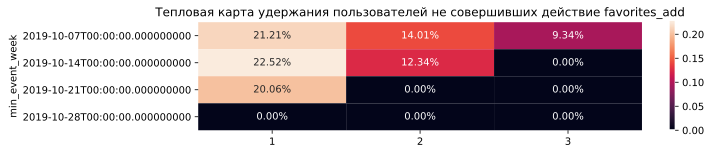

In [39]:
plt.figure(figsize=(10, 2))  # задаём размер графика
sns.heatmap(
    result_grouped_0.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания пользователей не совершивших действие favorites_add')  # название графика
plt.show()

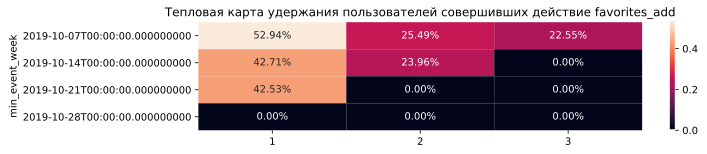

In [40]:
plt.figure(figsize=(10, 2))  # задаём размер графика
sns.heatmap(
    result_grouped_1.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания пользователей совершивших действие favorites_add')  # название графика
plt.show()

Retention Rate пользователей совершивших действие favorites_add заметно выше чем пользователей не совершавших это действие.

### Какие события чаще всего совершают пользователи, которые просматривают контакты? (Какие пользователи часто делают целевое событие (contacts_show))

In [41]:
events_0 = df_cat_0.groupby('event_name')['user_id'].agg(['count']).reset_index()
events_0.columns =['event_name', 'n_events']
events_0['%'] = (events_0['n_events']/(df_cat_0['user_id'].count()))*100
events_0 = events_0.sort_values(by='n_events', ascending=False)
display(events_0)

,event_name,n_events,%
7,tips_show,35695,57.176953
4,photos_show,7354,11.779782
5,search,5772,9.245703
0,advert_open,5213,8.350286
2,contacts_show,3746,6.000416
3,map,3485,5.582342
6,tips_click,716,1.146903
1,contacts_call,448,0.717615


In [42]:
events_1 = df_cat_1.groupby('event_name')['user_id'].agg(['count']).reset_index()
events_1.columns =['event_name', 'n_events']
events_1['%'] = (events_1['n_events']/(df_cat_1['user_id'].count()))*100
events_1 = events_1.sort_values(by='n_events', ascending=False)
display(events_1)

,event_name,n_events,%
8,tips_show,4360,37.049626
5,photos_show,2658,22.586676
3,favorites_add,1417,12.041128
6,search,1012,8.599592
0,advert_open,951,8.081237
2,contacts_show,783,6.653637
4,map,396,3.365058
7,tips_click,98,0.832767
1,contacts_call,93,0.790279


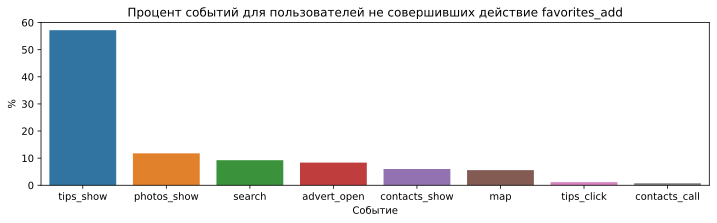

In [43]:
plt.figure(figsize=(12,3))
plt.title("Процент событий для пользователей не совершивших действие favorites_add")
sns.barplot(x='event_name', y='%', data=events_0, ci=None)
plt.xlabel("Событие")
plt.ylabel("%")
plt.show()

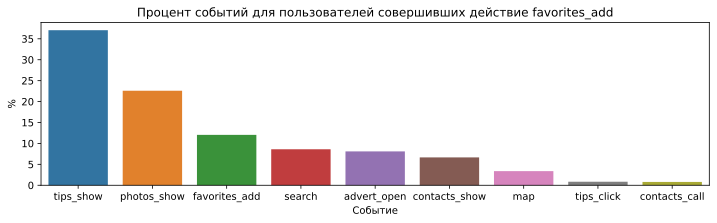

In [44]:
plt.figure(figsize=(12,3))
plt.title("Процент событий для пользователей совершивших действие favorites_add")
sns.barplot(x='event_name', y='%', data=events_1, ci=None)
plt.xlabel("Событие")
plt.ylabel("%")
plt.show()

Пользователи совершившие действие favorites_add чаще пользуются просмотром фотографий в объявлении и несколько реже поиском по сравнению с пользователями не совершавшими favorites_add.

Целевое событие contacts_show чаще на 0,65 % у пользователей совершивших действие favorites_add.

### Как различается время между распространенными событиями пользователей (например, различаются ли пользователи по группам на основе времени, которое проходит с момента первого использования мобильного приложения и до использования функции поиска)?

Расчитаем время, которое проходит с момента первого использования мобильного приложения и до использования функции поиска.

In [45]:
df_events = df.pivot_table(index=['user_id','event_date'], values='date_time', aggfunc=['min'])
df_events.columns = ['session_start']
df_events = df_events.reset_index()

In [46]:
df_search = df.query('event_name == "search"').pivot_table(index=['user_id','event_date','category'], values='date_time', aggfunc=['min'])
df_search.columns = ['search_start']
df_search = df_search.reset_index()

In [47]:
df_events_search = df_events.merge(df_search, on=['user_id','event_date'], how='left')
df_events_search['session_time'] = df_events_search['search_start'] - df_events_search['session_start']
df_events_search = df_events_search.dropna()
df_events_search = df_events_search.query('session_time < "0 days 01:00:00"').reset_index(drop=True)

In [48]:
df_events_search['session_time'] = df_events_search['session_time'].astype('timedelta64[s]')

In [49]:
display(df_events_search.pivot_table(index='category', values='session_time', aggfunc=['mean']))

,mean
,session_time
category,
0,97.399142
1,152.742938


Среднее время между первым использованием мобильного приложения и использованием функции поиска у пользователей совершившие действие favorites_add заметно выше.

В целом, пользователи совершавшие действие favorites_add (добавление объявления в избранное) имеют более лучшие показатели. Данная группа клиентов более "основательная". Что в целом логично: клиент увидел объявление - добавил в избранное - ушел - подумал (поискал информацию) - вернулся - посмотрел фото и т.д. Удержание, среднее время и конверсия при таком подходе будет логично выше.

### Формулировка и проверка статистических гипотез

* Проверка гипотезы различия конверсии в просмотры контактов между теми пользователями, которые установили приложение по ссылке из yandex и теми пользователями, которые установили приложение по ссылке из google.

Нулевая гипотеза: конверсия в просмотры контактов между теми пользователями, которые установили приложение по ссылке из yandex и пользователями, которые установили приложение по ссылке из google одинаковая

Альтернативная гипотеза: конверсия в просмотры контактов между теми пользователями, которые установили приложение по ссылке из yandex и пользователями, которые установили приложение по ссылке из google разная

Уровень значимости принимаем равным 0,05

Проводим Z-тест

In [50]:
yandex_all = df[df['source']=='yandex']['user_id'].nunique()
yandex_contacts_show = df[(df['source']=='yandex')&(df['event_name']=='contacts_show')]['user_id'].nunique()

google_all = df[df['source']=='google']['user_id'].nunique()
google_contacts_show = df[(df['source']=='google')&(df['event_name']=='contacts_show')]['user_id'].nunique()

p_yandex = yandex_contacts_show/yandex_all
p_google = google_contacts_show/google_all

p_combined = (yandex_contacts_show + google_contacts_show) / (yandex_all + google_all)

difference = p_yandex - p_google 

In [51]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/yandex_all + 1/google_all))
distr = st.norm(0, 1)

In [52]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

In [53]:
alpha = .05

In [54]:
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Конверсия в просмотры контактов между теми пользователями, которые установили приложение по ссылке из yandex и пользователями, которые установили приложение по ссылке из google одинаковая

### Проверка гипотезы различия конверсии в просмотры контактов между теми пользователями, которые совершили событие tips_click и теми пользователями, которые совершили события tips_click и favorites_add

Нулевая гипотеза: конверсия в просмотры контактов между теми пользователями, которые совершили событие tips_click и теми пользователями, которые совершили события tips_click и favorites_add одинаковая

Альтернативная гипотеза: конверсия в просмотры контактов между теми пользователями, которые совершили событие tips_click и теми пользователями, которые совершили события tips_click и favorites_add разная

Уровень значимости принимаем равным 0,05

Проводим Z-тест

In [55]:
favorites = df.query('event_name == "favorites_add"')
click = df.query('event_name == "tips_click"')

favorites_and_click = df[(df.user_id.isin(favorites.user_id)) & (df.user_id.isin(click.user_id))]
click_only = df[(df.user_id.isin(click.user_id))&~(df.user_id.isin(favorites.user_id))]

In [56]:
tips_click_all = click_only['user_id'].nunique()
tips_click_favorites_all = favorites_and_click['user_id'].nunique()
tips_click_contacts_show = click_only[click_only['event_name']=='contacts_show']['user_id'].nunique()
tips_click_contacts_show_favorites = favorites_and_click[favorites_and_click['event_name']=='contacts_show']['user_id'].nunique()



In [57]:
p_tips_click_contacts = tips_click_contacts_show/tips_click_all
p_tips_click_contacts_favorites = tips_click_contacts_show_favorites/tips_click_favorites_all

p_combined = (tips_click_contacts_show + tips_click_contacts_show_favorites) / (tips_click_all + tips_click_favorites_all)

difference = p_tips_click_contacts - p_tips_click_contacts_favorites 

In [58]:
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/tips_click_all + 1/tips_click_favorites_all))
distr = st.norm(0, 1)

In [59]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

alpha = .05

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.10199582460071888
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Конверсия в просмотры контактов между теми пользователями, которые совершили событие tips_click и теми пользователями, которые совершили события tips_click и favorites_add одинаковая

## Выводы

На основе проведенного анализа данных мобильного приложения "Ненужные вещи" можно сделать следующие выводы:

* больше всего пользователей в приложение привлечено с Яндекса;
* самое распространенное событие - tips_show (пользователь увидел рекомендованные объявления), не зависит от действий пользователя и показывается автоматически. На втором месте - photos_show, хотя пользователей его совершающих меньше чем search;
* среднее время сессии пользователя 12 минут;
* среднее количество уникальных пользователей в день 216;
* среднее количество уникальных пользователей в неделю 1189.

У пользователей совершивших действие favorites_add (добавление объявления в избранное) по сравнению с пользователями не совершавшими это действие:
* общая конверсия всех событий в целевое действие contacts_show (пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления) выше на 17,13 %;
* удержание выше;
* целевое событие contacts_show происходит чаще на 0,65 %
* среднее время между первым использованием мобильного приложения и использованием функции поиска выше.

Проверка статистических гипотез показала:
* конверсия в просмотры контактов между теми пользователями, которые установили приложение по ссылке из yandex и пользователями, которые установили приложение по ссылке из google одинаковая;
* конверсия в просмотры контактов между теми пользователями, которые совершили событие tips_click и теми пользователями, которые совершили события tips_click и favorites_add одинаковая.

Рекомендации:
* Необходимо уточнить затраты на рекламу в источниках привлечения. При одинаковой конверсии в целевое действие акцент на привлечение пользователей можно сделать на самый дешёвый источник. Тем самым сократив расходы.
* Мотивировать клиента добавлять объявления в избранное. В последующем напоминая ему о его выборе.


### Дашборд

In [60]:
df[['date_time', 'event_name', 'user_id', 'source']].reset_index().to_csv('project_final_tableau.csv', index = False)

### Ссылка на дашборд:

https://public.tableau.com/app/profile/timofey5386/viz/_16587415712900/Dashboard1?publish=yes

### Ссылка на презентацию

https://disk.yandex.ru/i/RnP1P3nMHlsIXg